<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->


# Learning Rate Finder

Setting the learning rate for stochastic gradient descent (SGD) is crucially important when training neural network because it controls both the speed of convergence and the ultimate performance of the network. Set the learning too low and you could be twiddling your thumbs for quite some time as the parameters update very slowly. Set it too high and the updates will skip over optimal solutions, or worse the optimizer might not converge at all!

Leslie Smith from the U.S. Naval Research Laboratory presented a method for finding a good learning rate in a paper called ["Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186). We implement this method in MXNet (with the Gluon API) and create a 'Learning Rate Finder' which you can use while training your own networks. We take a look at the central idea of the paper, cyclical learning rate schedules, in the ['Advanced Learning Rate Schedules'](./learning_rate_schedules_advanced.ipynb) tutorial.

## Simple Idea

Given an initialized network, a defined loss and a training dataset we take the following steps:

1. Train one batch at a time (a.k.a. an iteration)
2. Start with a very small learning rate (e.g. 0.000001) and slowly increase it every iteration
3. Record the training loss and continue until we see the training loss diverge

We then analyse the results by plotting a graph of the learning rate against the training loss as seen below (taking note of the log scales).

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_finder/finder_plot_w_annotations.png" width="500px"/> <!--notebook-skip-line-->

As expected, for very small learning rates we don't see much change in the loss as the parameter updates are negligible. At a learning rate of 0.001, we start to see the loss fall. Setting the initial learning rate here is reasonable, but we still have the potential to learn faster. We observe a drop in the loss up until 0.1 where the loss appears to diverge. We want to set the initial learning rate as high as possible before the loss becomes unstable, so we choose a learning rate of 0.05.

## Epoch to Iteration

Usually, our unit of work is an epoch (a full pass through the dataset) and the learning rate would typically be held constant throughout the epoch. With the Learning Rate Finder (and cyclical learning rate schedules) we are required to vary the learning rate every iteration. As such we structure our training code so that a single iteration can be run with a given learning rate. You can implement Learner as you wish. Just initialize the network, define the loss and trainer in `__init__` and keep your training logic for a single batch in `iteration`.

In [1]:
import mxnet as mx

# Set seed for reproducibility
mx.np.random.seed(42)

class Learner():
    def __init__(self, net, data_loader, device):
        """
        :param net: network (mx.gluon.Block)
        :param data_loader: training data loader (mx.gluon.data.DataLoader)
        :param device: device (mx.gpu or mx.cpu)
        """
        self.net = net
        self.data_loader = data_loader
        self.device = device
        # So we don't need to be in `for batch in data_loader` scope
        # and can call for next batch in `iteration`
        self.data_loader_iter = iter(self.data_loader)
        self.net.initialize(mx.init.Xavier(), device=self.device)
        self.loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
        self.trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .001})

    def iteration(self, lr=None, take_step=True):
        """
        :param lr: learning rate to use for iteration (float)
        :param take_step: take trainer step to update weights (boolean)
        :return: iteration loss (float)
        """
        # Update learning rate if different this iteration
        if lr and (lr != self.trainer.learning_rate):
            self.trainer.set_learning_rate(lr)
        # Get next batch, and move device (e.g. to GPU if set)
        data, label = next(self.data_loader_iter)
        data = data.to_device(self.device)
        label = label.to_device(self.device)
        # Standard forward and backward pass
        with mx.autograd.record():
            output = self.net(data)
            loss = self.loss_fn(output, label)
        loss.backward()
        # Update parameters
        if take_step: self.trainer.step(data.shape[0])
        # Set and return loss.
        self.iteration_loss = mx.np.mean(loss).item()
        return self.iteration_loss

    def close(self):
        # Close open iterator and associated workers
        self.data_loader_iter.shutdown()

We also adjust our `DataLoader` so that it continuously provides batches of data and doesn't stop after a single epoch. We can then call `iteration` as many times as required for the loss to diverge as part of the Learning Rate Finder process. We implement a custom `BatchSampler` for this, that keeps returning random indices of samples to be included in the next batch. We use the CIFAR-10 dataset for image classification to test our Learning Rate Finder.

In [2]:
from mxnet.gluon.data.vision import transforms

transform = transforms.Compose([
    # Switches HWC to CHW, and converts to `float32`
    transforms.ToTensor(),
    # Channel-wise, using pre-computed means and stds
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

dataset = mx.gluon.data.vision.datasets.CIFAR10(train=True).transform_first(transform)

class ContinuousBatchSampler():
    def __init__(self, sampler, batch_size):
        self._sampler = sampler
        self._batch_size = batch_size

    def __iter__(self):
        batch = []
        while True:
            for i in self._sampler:
                batch.append(i)
                if len(batch) == self._batch_size:
                    yield batch
                    batch = []

sampler = mx.gluon.data.RandomSampler(len(dataset))
batch_sampler = ContinuousBatchSampler(sampler, batch_size=128)
data_loader = mx.gluon.data.DataLoader(dataset, batch_sampler=batch_sampler)

[11:57:52] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


## Implementation

With preparation complete, we're ready to write our Learning Rate Finder that wraps the `Learner` we defined above. We implement a `find` method for the procedure, and `plot` for the visualization. Starting with a very low learning rate as defined by `lr_start` we train one iteration at a time and keep multiplying the learning rate by `lr_multiplier`. We analyse the loss and continue until it diverges according to `LRFinderStoppingCriteria` (which is defined later on). You may also notice that we save the parameters and state of the optimizer before the process and restore afterwards. This is so the Learning Rate Finder process doesn't impact the state of the model, and can be used at any point during training.

In [3]:
from matplotlib import pyplot as plt

class LRFinder():
    def __init__(self, learner):
        """
        :param learner: able to take single iteration with given learning rate and return loss
           and save and load parameters of the network (Learner)
        """
        self.learner = learner

    def find(self, lr_start=1e-6, lr_multiplier=1.1, smoothing=0.3):
        """
        :param lr_start: learning rate to start search (float)
        :param lr_multiplier: factor the learning rate is multiplied by at each step of search (float)
        :param smoothing: amount of smoothing applied to loss for stopping criteria (float)
        :return: learning rate and loss pairs (list of (float, float) tuples)
        """
        # Used to initialize weights; pass data, but don't take step.
        # Would expect for new model with lazy weight initialization
        self.learner.iteration(take_step=False)
        # Used to initialize trainer (if no step has been taken)
        if not self.learner.trainer._kv_initialized:
            self.learner.trainer._init_kvstore()
        # Store params and optimizer state for restore after lr_finder procedure
        # Useful for applying the method partway through training, not just for initialization of lr.
        self.learner.net.save_parameters("lr_finder.params")
        self.learner.trainer.save_states("lr_finder.state")
        lr = lr_start
        self.results = [] # List of (lr, loss) tuples
        stopping_criteria = LRFinderStoppingCriteria(smoothing)
        while True:
            # Run iteration, and block until loss is calculated.
            loss = self.learner.iteration(lr)
            self.results.append((lr, loss))
            if stopping_criteria(loss):
                break
            lr = lr * lr_multiplier
        # Restore params (as finder changed them)
        self.learner.net.load_parameters("lr_finder.params", device=self.learner.device)
        self.learner.trainer.load_states("lr_finder.state")
        return self.results

    def plot(self):
        lrs = [e[0] for e in self.results]
        losses = [e[1] for e in self.results]
        plt.figure(figsize=(6,8))
        plt.scatter(lrs, losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.yscale('log')
        axes = plt.gca()
        axes.set_xlim([lrs[0], lrs[-1]])
        y_lower = min(losses) * 0.8
        y_upper = losses[0] * 4
        axes.set_ylim([y_lower, y_upper])
        plt.show()

You can define the `LRFinderStoppingCriteria` as you wish, but empirical testing suggests using a smoothed average gives a more consistent stopping rule (see `smoothing`). We stop when the smoothed average of the loss exceeds twice the initial loss, assuming there have been a minimum number of iterations (see `min_iter`).

In [4]:
class LRFinderStoppingCriteria():
    def __init__(self, smoothing=0.3, min_iter=20):
        """
        :param smoothing: applied to running mean which is used for thresholding (float)
        :param min_iter: minimum number of iterations before early stopping can occur (int)
        """
        self.smoothing = smoothing
        self.min_iter = min_iter
        self.first_loss = None
        self.running_mean = None
        self.counter = 0

    def __call__(self, loss):
        """
        :param loss: from single iteration (float)
        :return: indicator to stop (boolean)
        """
        self.counter += 1
        if self.first_loss is None:
            self.first_loss = loss
        if self.running_mean is None:
            self.running_mean = loss
        else:
            self.running_mean = ((1 - self.smoothing) * loss) + (self.smoothing * self.running_mean)
        return (self.running_mean > self.first_loss * 2) and (self.counter >= self.min_iter)

## Usage

Using a Pre-activation ResNet-18 from the Gluon model zoo, we instantiate our Learner and fire up our Learning Rate Finder!

[11:57:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


[11:57:59] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


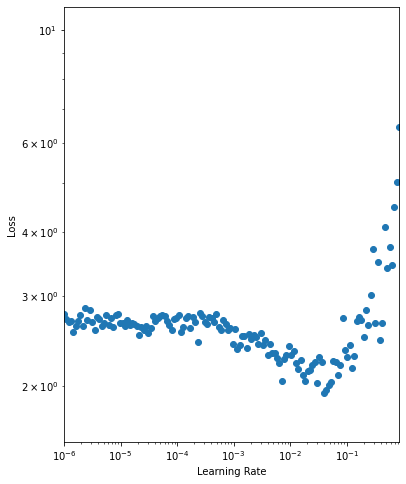

In [5]:
device = mx.gpu() if mx.device.num_gpus() else mx.cpu()
net = mx.gluon.model_zoo.vision.resnet18_v2(classes=10)
learner = Learner(net=net, data_loader=data_loader, device=device)
lr_finder = LRFinder(learner)
lr_finder.find(lr_start=1e-6)
lr_finder.plot()

![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/lr_finder/finder_plot.png) <!--notebook-skip-line-->


As discussed before, we should select a learning rate where the loss is falling (i.e. from 0.001 to 0.05) but before the loss starts to diverge (i.e. 0.1). We prefer higher learning rates where possible, so we select an initial learning rate of 0.05. Just as a test, we will run 500 epochs using this learning rate and evaluate the loss on the final batch. As we're working with a single batch of 128 samples, the variance of the loss estimates will be reasonably high, but it will give us a general idea. We save the initialized parameters for a later comparison with other learning rates.

In [6]:
learner.net.save_parameters("net.params")
lr = 0.05

for iter_idx in range(300):
    learner.iteration(lr=lr)
    if ((iter_idx % 100) == 0):
        print("Iteration: {}, Loss: {:.5g}".format(iter_idx, learner.iteration_loss))
print("Final Loss: {:.5g}".format(learner.iteration_loss))

Iteration: 0, Loss: 2.6897


Iteration: 100, Loss: 1.4824


Iteration: 200, Loss: 1.3333


Final Loss: 1.1727


Iteration: 0, Loss: 2.785 <!--notebook-skip-line-->

Iteration: 100, Loss: 1.6653 <!--notebook-skip-line-->

Iteration: 200, Loss: 1.4891 <!--notebook-skip-line-->


Final Loss: 1.1812 <!--notebook-skip-line-->


We see a sizable drop in the loss from approx. 2.7 to 1.2.

And now we have a baseline, let's see what happens when we train with a learning rate that's higher than advisable at 0.5.

In [7]:
net = mx.gluon.model_zoo.vision.resnet18_v2(classes=10)
learner = Learner(net=net, data_loader=data_loader, device=device)
learner.net.load_parameters("net.params", device=device)
lr = 0.5

for iter_idx in range(300):
    learner.iteration(lr=lr)
    if ((iter_idx % 100) == 0):
        print("Iteration: {}, Loss: {:.5g}".format(iter_idx, learner.iteration_loss))
print("Final Loss: {:.5g}".format(learner.iteration_loss))

Iteration: 0, Loss: 2.6786


Iteration: 100, Loss: 2.1072


Iteration: 200, Loss: 1.713


Final Loss: 1.3782


Iteration: 0, Loss: 2.6469 <!--notebook-skip-line-->

Iteration: 100, Loss: 1.9666 <!--notebook-skip-line-->

Iteration: 200, Loss: 1.6919 <!--notebook-skip-line-->


Final Loss: 1.366 <!--notebook-skip-line-->


We still observe a fall in the loss but aren't able to reach as low as before.

And lastly, we see how the model trains with a more conservative learning rate of 0.005.

In [8]:
net = mx.gluon.model_zoo.vision.resnet18_v2(classes=10)
learner = Learner(net=net, data_loader=data_loader, device=device)
learner.net.load_parameters("net.params", device=device)
lr = 0.005

for iter_idx in range(300):
    learner.iteration(lr=lr)
    if ((iter_idx % 100) == 0):
        print("Iteration: {}, Loss: {:.5g}".format(iter_idx, learner.iteration_loss))
print("Final Loss: {:.5g}".format(learner.iteration_loss))

Iteration: 0, Loss: 2.7294


Iteration: 100, Loss: 1.8816


Iteration: 200, Loss: 1.6372


Final Loss: 1.7627


Iteration: 0, Loss: 2.605 <!--notebook-skip-line-->

Iteration: 100, Loss: 1.8621 <!--notebook-skip-line-->

Iteration: 200, Loss: 1.6316 <!--notebook-skip-line-->


Final Loss: 1.2919 <!--notebook-skip-line-->


Although we get quite similar results to when we set the learning rate at 0.05 (because we're still in the region of falling loss on the Learning Rate Finder plot), we can still optimize our network faster using a slightly higher rate.

## Wrap Up

Give Learning Rate Finder a try on your current projects, and experiment with the different learning rate schedules found in the [basic learning rate tutorial](./learning_rate_schedules.ipynb) and the [advanced learning rate tutorial](./learning_rate_schedules_advanced.ipynb).

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->